### **Due Date**
2/29/2024 at 11:59PM EST

# **Introduction**

Welcome to Assignment 2 of 4756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC) and dataset aggregation (DAgger) methods
* **Extra Credit:** Get imitation learning working under causal confounds

You will use the Hopper agent for this assignment, which is part of Gym’s Mujoco Environments. Refer to the Gym website for more details about the [Hopper environment](https://gymnasium.farama.org/environments/mujoco/hopper/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started:** This assignment should be completed in [Google Colab](https://colab.research.google.com/). In order to access the python files bc.py and dagger.py which you will be editing, it is necessary to first upload the folder A2_FILES to your google drive and then mount your Google Drive in Colab. To do so, carefully follow the directions below in the section **Mounting Google Drive to Colab**, or reference the instructions [here](https://saturncloud.io/blog/how-to-import-python-files-in-google-colaboratory/). Additionally, make sure to switch your runtime type to GPU; this will help speed up the training process.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


### **Imports**

In [ ]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [713 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,073 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,505 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym

!pip install free-mujoco-py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.9.0
!pip install -U colabgymrender
!pip install mujoco

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 47 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [ ]:
import gym
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Mounting Google Drive in Colab**

Before you complete this step, make sure that you have uploaded the folder A2_FILES to your Google Drive. Once you have done that, you need to mount your Google Drive in Colab. In order to do so, run the cell below. Running this cell will prompt you to authorize Colab to access your drive. Follow the instructions to complete the authorization process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Next, locate A2_FILES on the left panel in Colab. To do so, navigate to Files/drive/MyDrive. At this point, you should see the contents of your Google Drive. Locate A2_FILES in your drive, and if necessary, modify the cell below such that you are correctly indicating the file path to A2_FILES. You will append the path to A2_FILES to the system path. If you have completed this step correctly, you should be able to successfully import the BC and DAgger modules into this notebook.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/A2_FILES')

### **Setting Up the Environment**

In [ ]:
def make_env(env_id, seed=42, p_tremble=0.0):
    env = gym.make(env_id, render_mode=None) # Change render_mode = rbg_array to render
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
env = make_env('Hopper-v3')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Hopper-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

### **Visualizing the Hopper environment with random actions**

We have provided functions to visualize the environment and compute rewards on the Hopper environment with random actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

Total Reward using Random Actions =  36.194235803705816


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


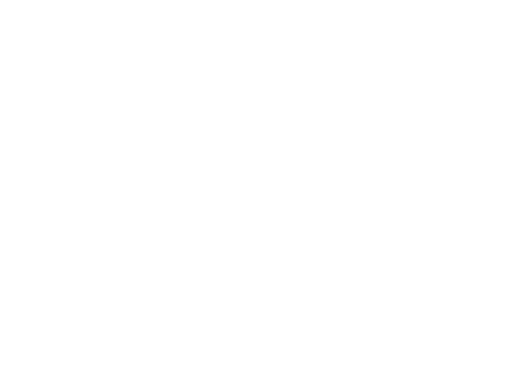

In [ ]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
obs = env.reset()
total_random_reward = 0
i = 0
while not done:
    i += 1
    if i%5==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_random_reward += reward
    if done:
        break
print("Total Reward using Random Actions = ", total_random_reward)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Approximate expected reward for total reward using random actions: 27**

In [ ]:
# Download Hopper expert policy
!wget https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt

--2024-02-27 22:32:57--  https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt [following]
--2024-02-27 22:32:58--  https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284515 (278K) [application/octet-stream]
Saving to: ‘hopper.pt’

hopper.pt           100%[===================>] 277.85K  --.-KB/s    in 0.04s   

2

### **Neural Networks in PyTorch**

We have provided some code for implementing simple neural networks (fully connected, multilayer perceptrons) in PyTorch, including the ExpertActor and Learner classes. We have also provided code for checkpointing for saving your best performing model. If you wish to learn more about how to construct and train neural networks in PyTorch, check out the tutorials on [pytorch.org](https://pytorch.org/).

### ExpertActor Class

In [ ]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class ExpertActor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.action_space.high - env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.action_space.high + env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_expert_action(self, obs, random_prob=0.0):
        if np.random.random() < random_prob:
            return env.action_space.sample()
        else:
            action = self.get_action(torch.tensor([obs]).float())
            return np.array(action[0][0].detach().cpu())

ckpt_path = "hopper.pt"
expert = ExpertActor(env).to('cpu')
expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))

<All keys matched successfully>

### Learner Class

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Learner(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor([obs]).float().to(device))
        return np.array(action[0].detach().cpu())

### Checkpointing Functions

In [ ]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    return 'best_model_checkpoint.pth'

def load_model_checkpoint(checkpoint_path):
    """Load a model checkpoint from disk.

    Parameters:
        checkpoint_path (str)
            The path to load the checkpoint from

    Returns:
        model (torch.nn.Module)
            The model loaded from the checkpoint
    """
    model = Learner(env)
    model.load_state_dict(torch.load(checkpoint_path))
    return model

### **Visualizing the Hopper environment with the expert policy**

We have provided a visualization for computing rewards using the expert policy on the Hopper environment.

<ipython-input-11-8f71eb64b2f0>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  action = self.get_action(torch.tensor([obs]).float())


Total Reward using Expert Policy = 3485.88026939468
Total Reward using Random Actions = 36.194235803705816



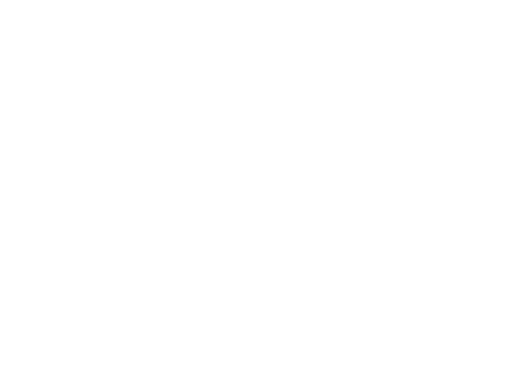

In [ ]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
reseed(1)
obs = env.reset(seed=1)
total_expert_reward = 0
i = 0
while not done:
    i += 1
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert.get_expert_action(obs)
    obs, reward, done, info = env.step(action)
    total_expert_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

**Approximate expected reward for total reward using expert policy: 2238**

### **Data collection**

We have provided some code to collect 50 demonstrations using the expert policy. To collect a different number of  trajectories, change the value of the NUM_TRAJS variable.

### Collecting and processing offline data

In [ ]:
### Collecting trajectories (i.e. demonstrations) using the expert policy


NUM_TRAJS = 50
observations, actions = [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS)):
    print("Collecting trajectory ", traj_num+1)
    done = False
    obs = env.reset(seed = 1)
    while not done:
        with torch.no_grad():
            action = expert.get_expert_action(obs)
            observations.append(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
        if done:
            break

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:48,  1.02it/s]

  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

  6%|▌         | 3/50 [00:02<00:31,  1.51it/s]

  8%|▊         | 4/50 [00:03<00:35,  1.30it/s]

 10%|█         | 5/50 [00:03<00:32,  1.40it/s]

 12%|█▏        | 6/50 [00:04<00:30,  1.43it/s]

 14%|█▍        | 7/50 [00:05<00:30,  1.43it/s]

 16%|█▌        | 8/50 [00:05<00:30,  1.40it/s]

 18%|█▊        | 9/50 [00:06<00:31,  1.30it/s]

 20%|██        | 10/50 [00:07<00:28,  1.39it/s]

 22%|██▏       | 11/50 [00:08<00:28,  1.35it/s]

 24%|██▍       | 12/50 [00:08<00:28,  1.34it/s]

 26%|██▌       | 13/50 [00:09<00:30,  1.23it/s]

 28%|██▊       | 14/50 [00:10<00:28,  1.27it/s]

 30%|███       | 15/50 [00:11<00:27,  1.28it/s]

 32%|███▏      | 16/50 [00:12<00:28,  1.19it/s]

 34%|███▍      | 17/50 [00:13<00:28,  1.15it/s]

 36%|███▌      | 18/50 [00:14<00:30,  1.06it/s]

 38%|███▊      | 19/50 [00:14<00:25,  1.20it/s]

 40%|████      | 20/50 [00:15<00:24,  1.20it/s]

 42%|████▏     | 21/50 [00:16<00:22,  1.28it/s]

 44%|████▍     | 22/50 [00:17<00:20,  1.35it/s]

 46%|████▌     | 23/50 [00:17<00:20,  1.33it/s]

 48%|████▊     | 24/50 [00:18<00:19,  1.36it/s]

 50%|█████     | 25/50 [00:19<00:18,  1.39it/s]

 52%|█████▏    | 26/50 [00:19<00:16,  1.45it/s]

 54%|█████▍    | 27/50 [00:20<00:15,  1.44it/s]

 56%|█████▌    | 28/50 [00:21<00:16,  1.30it/s]

 58%|█████▊    | 29/50 [00:22<00:15,  1.39it/s]

 60%|██████    | 30/50 [00:22<00:13,  1.45it/s]

 62%|██████▏   | 31/50 [00:23<00:14,  1.33it/s]

 64%|██████▍   | 32/50 [00:24<00:12,  1.41it/s]

 66%|██████▌   | 33/50 [00:24<00:11,  1.42it/s]

 68%|██████▊   | 34/50 [00:25<00:12,  1.28it/s]

 70%|███████   | 35/50 [00:26<00:12,  1.20it/s]

 72%|███████▏  | 36/50 [00:27<00:11,  1.20it/s]

 74%|███████▍  | 37/50 [00:28<00:10,  1.27it/s]

 76%|███████▌  | 38/50 [00:28<00:08,  1.34it/s]

 78%|███████▊  | 39/50 [00:29<00:07,  1.49it/s]

 80%|████████  | 40/50 [00:30<00:06,  1.49it/s]

 82%|████████▏ | 41/50 [00:30<00:05,  1.50it/s]

 84%|████████▍ | 42/50 [00:31<00:05,  1.56it/s]

 86%|████████▌ | 43/50 [00:32<00:04,  1.52it/s]

 88%|████████▊ | 44/50 [00:32<00:03,  1.52it/s]

 90%|█████████ | 45/50 [00:33<00:03,  1.51it/s]

 92%|█████████▏| 46/50 [00:34<00:02,  1.40it/s]

 94%|█████████▍| 47/50 [00:34<00:01,  1.52it/s]

 96%|█████████▌| 48/50 [00:35<00:01,  1.58it/s]

 98%|█████████▊| 49/50 [00:36<00:00,  1.40it/s]

100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


# **Q1: Behavior Cloning (BC) with Shaky Hands**

To begin, fill in the implementation for the training loop function in **bc.py** found in **A2_FILES**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take roughly 15 minutes.

### Train Behavior Cloning (BC) Model

In [ ]:
import bc

bc_learner = Learner(env)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)


36164
36164


100%|██████████| 1500/1500 [15:58<00:00,  1.56it/s]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Visualize the learner policy and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Reward using Expert Policy = 3485.88026939468
Total Reward using Learned Policy = 775.2034482418003



**Approximate expected reward for total reward using learned policy: 1000**

Most likely, the performance of your BC agent will be very close to the expert.  However, what happens if your learner has SHAKY HANDS, i.e it executes random actions every few timesteps?

Concretely, set the probability of a random action by the learner to be just 5% (code already provided). You will probably see that the performance of the learner tanks!

### Add 1% random actions to learner and check rewards

In [ ]:
bc_learner.random_prob = 0.05
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
reseed(2)
bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)

36164
36164


100%|██████████| 1500/1500 [15:32<00:00,  1.61it/s]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Visualize learner policy with random actions and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed=2)
total_learner_reward = 0
i= 0 #Makes sense. When I click connect it does not allow me to connect for some reason. When does the limit reset?

while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy (Random Actions)= {total_learner_reward}\n")

Total Reward using Expert Policy = 3485.88026939468
Total Reward using Learned Policy (Random Actions)= 1071.4115324537147



**Approximate expected reward for total reward using learned policy with 1% random actions: 111**

# **Q2: DAgger**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome shaky hands with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **dagger.py** found in **A2_FILES**.

Remember to initialize the DAgger policy with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.



### Initialize DAgger with BC

In [ ]:
dagger_learner = bc_learner
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Interact with the environment using the learner policy with random actions

In [ ]:
import dagger

observations, actions = [], []
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
dagger.interact(env, dagger_learner, expert, observations, actions, checkpoint_path, seed, num_epochs = 500)

After interaction 0, reward = 453.44595157710404
152
152


100%|██████████| 500/500 [00:02<00:00, 212.54it/s]


After interaction 1, reward = 254.12791021083254
251
251


100%|██████████| 500/500 [00:02<00:00, 196.54it/s]


After interaction 2, reward = 597.4385463737735
440
440


100%|██████████| 500/500 [00:04<00:00, 120.70it/s]


After interaction 3, reward = 133.123261916145
503
503


100%|██████████| 500/500 [00:04<00:00, 101.97it/s]


After interaction 4, reward = 456.564139065154
651
651


100%|██████████| 500/500 [00:06<00:00, 76.53it/s]


After interaction 5, reward = 477.4315421515624
805
805


100%|██████████| 500/500 [00:08<00:00, 56.21it/s]


After interaction 6, reward = 378.33826500800876
935
935


100%|██████████| 500/500 [00:08<00:00, 59.10it/s]


After interaction 7, reward = 46.401170930745096
971
971


100%|██████████| 500/500 [00:09<00:00, 51.44it/s]


After interaction 8, reward = 197.49916943138683
1054
1054


100%|██████████| 500/500 [00:11<00:00, 45.17it/s]


After interaction 9, reward = 472.17742028184466
1205
1205


100%|██████████| 500/500 [00:11<00:00, 42.99it/s]


After interaction 10, reward = 194.48192876129056
1287
1287


100%|██████████| 500/500 [00:13<00:00, 38.41it/s]


After interaction 11, reward = 192.9284722527989
1368
1368


100%|██████████| 500/500 [00:13<00:00, 37.54it/s]


After interaction 12, reward = 231.22946852378197
1460
1460


100%|██████████| 500/500 [00:13<00:00, 36.47it/s]


After interaction 13, reward = 357.9279753322701
1585
1585


100%|██████████| 500/500 [00:15<00:00, 32.53it/s]


After interaction 14, reward = 616.6966093934074
1763
1763


100%|██████████| 500/500 [00:15<00:00, 31.76it/s]


After interaction 15, reward = 252.1707816893648
1862
1862


100%|██████████| 500/500 [00:18<00:00, 26.91it/s]


After interaction 16, reward = 189.3660227158271
1942
1942


100%|██████████| 500/500 [00:17<00:00, 27.97it/s]


After interaction 17, reward = 246.58290126742682
2038
2038


100%|██████████| 500/500 [00:18<00:00, 26.52it/s]


After interaction 18, reward = 336.54202308808783
2159
2159


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


After interaction 19, reward = 538.3711639416318
2327
2327


100%|██████████| 500/500 [00:22<00:00, 22.10it/s]


After interaction 20, reward = 121.93004707802098
2388
2388


100%|██████████| 500/500 [00:22<00:00, 22.22it/s]


After interaction 21, reward = 461.64193642276086
2537
2537


100%|██████████| 500/500 [00:22<00:00, 21.90it/s]


After interaction 22, reward = 62.292703713705386
2581
2581


100%|██████████| 500/500 [00:24<00:00, 20.67it/s]


After interaction 23, reward = 237.65391845211886
2677
2677


100%|██████████| 500/500 [00:24<00:00, 20.29it/s]


After interaction 24, reward = 227.46973566998895
2768
2768


100%|██████████| 500/500 [00:24<00:00, 20.27it/s]


After interaction 25, reward = 510.08100619990046
2933
2933


100%|██████████| 500/500 [00:26<00:00, 18.85it/s]


After interaction 26, reward = 15.988752422576843
2949
2949


100%|██████████| 500/500 [00:27<00:00, 18.50it/s]


After interaction 27, reward = 19.97804245721543
2968
2968


100%|██████████| 500/500 [00:27<00:00, 18.51it/s]


After interaction 28, reward = 197.56421990798674
3050
3050


100%|██████████| 500/500 [00:26<00:00, 18.62it/s]


After interaction 29, reward = 634.743652603044
3253
3253


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]


After interaction 30, reward = 20.048126034570195
3272
3272


100%|██████████| 500/500 [00:29<00:00, 17.18it/s]


After interaction 31, reward = 129.8395066382038
3334
3334


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]


After interaction 32, reward = 297.5828588469051
3443
3443


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


After interaction 33, reward = 453.8411581189547
3591
3591


100%|██████████| 500/500 [00:32<00:00, 15.54it/s]


After interaction 34, reward = 456.47592120881626
3737
3737


100%|██████████| 500/500 [00:32<00:00, 15.46it/s]


After interaction 35, reward = 32.80036738872725
3766
3766


100%|██████████| 500/500 [00:33<00:00, 15.14it/s]


After interaction 36, reward = 272.06714676883496
3869
3869


100%|██████████| 500/500 [00:35<00:00, 14.05it/s]


After interaction 37, reward = 50.447253719219496
3907
3907


100%|██████████| 500/500 [00:34<00:00, 14.45it/s]


After interaction 38, reward = 623.9666558922498
4100
4100


100%|██████████| 500/500 [00:36<00:00, 13.68it/s]


After interaction 39, reward = 334.0522295234127
4220
4220


100%|██████████| 500/500 [00:37<00:00, 13.47it/s]


After interaction 40, reward = 726.0175404359425
4440
4440


100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


After interaction 41, reward = 456.20141545897894
4588
4588


100%|██████████| 500/500 [00:39<00:00, 12.77it/s]


After interaction 42, reward = 514.4922703626057
4755
4755


100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


After interaction 43, reward = 492.3309990171266
4915
4915


100%|██████████| 500/500 [00:42<00:00, 11.64it/s]


After interaction 44, reward = 244.43018220476017
5009
5009


100%|██████████| 500/500 [00:42<00:00, 11.90it/s]


After interaction 45, reward = 723.3970800681936
5229
5229


100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


After interaction 46, reward = 619.1226184203234
5422
5422


100%|██████████| 500/500 [00:46<00:00, 10.82it/s]


After interaction 47, reward = 592.7853713549904
5605
5605


100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


After interaction 48, reward = 730.0229363487072
5824
5824


100%|██████████| 500/500 [00:49<00:00, 10.10it/s]


After interaction 49, reward = 217.36441095093588
5914
5914


100%|██████████| 500/500 [00:50<00:00,  9.88it/s]


After interaction 50, reward = 58.07552948271883
5956
5956


100%|██████████| 500/500 [00:49<00:00, 10.09it/s]


After interaction 51, reward = 1185.322825294243
6286
6286


100%|██████████| 500/500 [00:53<00:00,  9.33it/s]


After interaction 52, reward = 500.9970857931765
6448
6448


100%|██████████| 500/500 [00:56<00:00,  8.79it/s]


After interaction 53, reward = 60.32991165934098
6491
6491


100%|██████████| 500/500 [00:56<00:00,  8.86it/s]


After interaction 54, reward = 893.3655728794238
6770
6770


100%|██████████| 500/500 [00:59<00:00,  8.44it/s]


After interaction 55, reward = 257.5347910637732
6871
6871


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


After interaction 56, reward = 251.21439253046123
6968
6968


100%|██████████| 500/500 [01:01<00:00,  8.13it/s]


After interaction 57, reward = 926.490991711678
7232
7232


100%|██████████| 500/500 [01:04<00:00,  7.77it/s]


After interaction 58, reward = 946.7622768635359
7496
7496


100%|██████████| 500/500 [01:06<00:00,  7.53it/s]


After interaction 59, reward = 797.3511739039928
7728
7728


100%|██████████| 500/500 [01:09<00:00,  7.16it/s]


After interaction 60, reward = 722.2873449873315
7944
7944


100%|██████████| 500/500 [01:10<00:00,  7.10it/s]


After interaction 61, reward = 561.5987418276848
8124
8124


100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


After interaction 62, reward = 1074.163976557742
8442
8442


100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


After interaction 63, reward = 423.70351575461933
8585
8585


100%|██████████| 500/500 [01:16<00:00,  6.52it/s]


After interaction 64, reward = 479.88824707139935
8743
8743


100%|██████████| 500/500 [01:19<00:00,  6.31it/s]


After interaction 65, reward = 62.04287746774814
8787
8787


100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


After interaction 66, reward = 958.2240314687517
9067
9067


100%|██████████| 500/500 [01:21<00:00,  6.11it/s]


After interaction 67, reward = 694.3143768000417
9269
9269


100%|██████████| 500/500 [01:22<00:00,  6.10it/s]


After interaction 68, reward = 875.485399929283
9524
9524


100%|██████████| 500/500 [01:25<00:00,  5.88it/s]


After interaction 69, reward = 1324.427391876177
9888
9888


100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


After interaction 70, reward = 469.5701427936233
10041
10041


100%|██████████| 500/500 [01:28<00:00,  5.63it/s]


After interaction 71, reward = 567.5816706492836
10220
10220


100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


After interaction 72, reward = 339.53658650196263
10342
10342


100%|██████████| 500/500 [01:30<00:00,  5.50it/s]


After interaction 73, reward = 781.8482762355204
10576
10576


100%|██████████| 500/500 [01:32<00:00,  5.41it/s]


After interaction 74, reward = 649.9165695523765
10776
10776


100%|██████████| 500/500 [01:33<00:00,  5.35it/s]


After interaction 75, reward = 1204.7206120391368
11101
11101


100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


After interaction 76, reward = 463.0826563822498
11251
11251


100%|██████████| 500/500 [01:37<00:00,  5.15it/s]


After interaction 77, reward = 1035.8630131821658
11529
11529


100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


After interaction 78, reward = 1023.6157946223227
11814
11814


100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


After interaction 79, reward = 340.7553820530094
11936
11936


100%|██████████| 500/500 [01:46<00:00,  4.70it/s]


After interaction 80, reward = 1392.5855180082772
12288
12288


100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


After interaction 81, reward = 1379.7929318723577
12640
12640


100%|██████████| 500/500 [01:54<00:00,  4.36it/s]


After interaction 82, reward = 1098.853658674648
12945
12945


100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


After interaction 83, reward = 803.5227721658429
13186
13186


100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


After interaction 84, reward = 713.1671155485179
13398
13398


100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


After interaction 85, reward = 372.7182449461302
13530
13530


100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


After interaction 86, reward = 791.1614881961784
13768
13768


100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


After interaction 87, reward = 1344.1652161712875
14113
14113


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


After interaction 88, reward = 229.4277267149509
14205
14205


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


After interaction 89, reward = 460.20270247360884
14355
14355


100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


After interaction 90, reward = 864.5211070255042
14595
14595


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


After interaction 91, reward = 1051.0662460976534
14875
14875


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


After interaction 92, reward = 1429.9817240449458
15270
15270


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


After interaction 93, reward = 132.45096485684272
15333
15333


100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


After interaction 94, reward = 911.0841569287408
15594
15594


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


After interaction 95, reward = 747.4243180864704
15817
15817


100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


After interaction 96, reward = 802.870801135893
16048
16048


100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


After interaction 97, reward = 469.47446377783467
16205
16205


100%|██████████| 500/500 [02:22<00:00,  3.51it/s]


After interaction 98, reward = 809.1562252902626
16446
16446


100%|██████████| 500/500 [02:25<00:00,  3.44it/s]


After interaction 99, reward = 466.70768227045863
16597
16597


100%|██████████| 500/500 [02:25<00:00,  3.43it/s]


**Approximate expected reward for 100th interaction with the environment: 1328**

# **Extra Credit: Causal Confounds**

Congratulations, you made it! You have implemented your first few (“deep” :') ) imitation learning algorithms in PyTorch.

With that in mind, let’s dig a little deeper. A common problem in the real world is hidden information. What if parts of the robot's state are hidden from the learner? How well does imitation learning do when the expert has full state knowledge, but the learner does not?

You will need to:
* Create a “partially observable” Hopper environment where the last observation index (refer to Gym documentation) is hidden from the learner (note that it’s still available to the expert!)
* Obtain rewards for both BC and DAgger. How well do BC and DAgger work for the partially observable Hopper environment? Explain the performance of each.

**Note:** For this part, BC and DAgger should just work if you did things right.


In [ ]:
#Just to add some code here for creating the new environment
from gym.spaces import Box

env = make_env('Hopper-v3')
env.observation_space =  observation_space = Box(
                low=-np.inf, high=np.inf, shape=(10,), dtype=np.float64
            )
bc_learner = Learner(env)
bc_learner.to(device)

truncated_observations =[observation[:-1] for observation in observations]

#checkpoint_path = get_checkpoint_path("bc")
#reseed(2)
bc.train(bc_learner, truncated_observations, actions, checkpoint_path, num_epochs = 1500)

#partially observabale environment
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

In [ ]:
dagger_learner = bc_learner
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)


observations, actions = [], []
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
dagger.interact(env, dagger_learner, expert, observations, actions, checkpoint_path, seed, num_epochs = 500)


In [ ]:
import bc
import torch

def interact_2(env, learner, expert, observations, actions, checkpoint_path, seed, num_epochs=100):
  """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert (ExpertActor)
            An ExpertActor object (expert policy)
        observations (list of numpy.ndarray)
            An initially empty list of numpy arrays
        actions (list of numpy.ndarray)
            An initially empty list of numpy arrays
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
  # Interact with the environment and aggregate your BC Dataset by querying the expert
  NUM_INTERACTIONS = 100
  for episode in range(NUM_INTERACTIONS):
      total_learner_reward = 0
      done = False
      obs = env.reset(seed=seed)
      while not done:
        # TODO: Implement Hopper environment interaction and dataset aggregation here
        truncated_observations =[obs[:-1] for observation in obs]
        action = learner.get_action(truncated_observations)
        observations.append(obs)
        expertAction = expert.get_expert_action(obs)
        obs,reward,done,_=env.step(action)
        total_learner_reward+=reward
        actions.append(expertAction)
        if done:
          break
      print(f"After interaction {episode}, reward = {total_learner_reward}")
      bc.train(learner, observations, actions, checkpoint_path, num_epochs)